# Capstone Project - Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)

## Introduction: Business Problem <a name="introduction"></a>

Seattle is a wonderful city, but my job is relocating me to another location. I am offered the option of going to Austin, Portland, Denver, or Baltimore. I like Seattle and the neighborhood I live in with the restaurants, breweries, coffee shops and bars all within walking distance of my house. Can I find neighborhoods in these new cities with these same types of establishments and similar housing costs and area demographics? 

I will use my data science powers to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by my family.

## Data <a name="data"></a>

Based on definition of the problem, factors that will influence the decision are:
* similarity of venues across neighborhoods
* population density
* average housing cost

I will be using a polygon shapefile includes neighborhood boundaries supplied by Zillow.com, the Los Angeles Times and the City of Denver together with a number of demographic variables from the 2010 U.S. census (downloadable from (https://geo.nyu.edu/catalog/stanford-xq082nw3443).

Following data sources will be needed to extract/generate the required information:
* centers of neighborhoods are defined in the shapefile
* neighborhood boundaries are defined in the shapefile
* neighborhood demographics are defined in the shapefile
* city centers with be obtained using **Geopy Geocoders**
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**

The geo_json is a list of dictionaries. There are also more data fields than are needed for the data modeling. Only the following fields are needed. The remaining fields can be discarded. 
* state: State
* city: City
* name: Neighborhood Name
* x: Neighborhood Centroid Latitude
* y: Neighborhood Centroid Longitude
* avg_hval: Average Home Value
* pct_own: Percentage of Owned Homes
* pct_rent: Percentage of Rented Homes
* medage_cy: Median Age of Residents
* popdensity: Population Density
* geometry: Neighborhood Boundary Box

Rearrange the contents of this json into a dataframe with the boundary box attached

In [4]:
import json
import pandas as pd 

with open('stanford-xq082nw3443-geojson.json') as json_data:
    all_data = json.load(json_data)

# cut down the data
neighborhoods_data = all_data['features']

# narrow the cities from dataset to only those to be included in the project
target_cities = ['Denver', 'Seattle', 'Austin', 'Portland', 'Phoenix']

# define the dataframe columns
column_names = ['City', 'State','Neighborhood', 'Latitude', 'Longitude', 'Home Ownership',
       'Home Rentership', 'Home Value', 'Median Age', 'Population Denisty',
       'Boundary Box'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# build the neighborhood dataframe from the json
for data in neighborhoods_data:
    # only include target cities
    if data['properties']['city'] not in target_cities:
        pass
    else:
        city =  data['properties']['city'] 
        state = data['properties']['state']
        neighborhood_name = data['properties']['name']
        neighborhood_lat = data['properties']['y']
        neighborhood_lon = data['properties']['x']
        home_val = data['properties']['avg_hval']
        home_own = data['properties']['pct_own']
        home_rent = data['properties']['pct_rent']
        median_age = data['properties']['medage_cy']
        pop_density = data['properties']['popdensity']
        boundary_box = data['geometry']
        neighborhoods = neighborhoods.append({'City': city,
                                              'State': state,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon,
                                              'Home Value': home_val,
                                              'Home Ownership': home_own,
                                              'Home Rentership': home_rent,
                                              'Median Age': median_age,
                                              'Population Denisty': pop_density,
                                              'Boundary Box': boundary_box
                                             }, ignore_index=True)

# add a new column with Neighborhood and City concatanated so that data can be sorted by city and neighborhoods.
# I don't expect all the neighborhood names to be unique and no overlap in another city        
neighborhoods['Name_City'] = neighborhoods['Neighborhood'] + '_' + neighborhoods['City']


Not all of the data from this source is needed for this project. I only want to save some of the columns for the remainder of the project. The dataframe will. be saved to csv for easy loading. The boundary boxes will be used to make individual city jsons next. 

In [5]:
save_columns = ['Name_City','City', 'State','Neighborhood', 'Latitude', 'Longitude', 'Home Ownership',
       'Home Rentership', 'Home Value', 'Median Age', 'Population Denisty']
neighborhoods[save_columns].to_csv('neighborhoods.csv', index = False)

Create a json for each target city with the boundary boxes for each neighborhood. Save the json with the city name to be used in the Choropleth maps later.

In [3]:
for city in neighborhoods.City.unique():
    temp_df = neighborhoods[neighborhoods['City'] == city]
    geo_json = {"type":"FeatureCollection",
            "features":[]}
    for i, row in temp_df.iterrows():
        geo_json['features'].append(
                {"type":
                 "Feature",
                 "id": row['Neighborhood'],
                 "properties":{
                     "name": row['Neighborhood']}
                 ,"geometry": row['Boundary Box']})


    with open(f'{city}_geo.json', 'w') as fp:
        json.dump(geo_json, fp)

Load the neighborhoods dataframe from the csv saved earlier to save time in future work

In [6]:
neighborhoods = pd.read_csv('neighborhoods.csv')

### Using Foursquare
Now that the neighborhoods and their locations have been identified I can use the Foursquare API to get info on various venues in each neighborhood.

Create the url for searching foursquare

In [ ]:
CLIENT_ID = 'xxxxxxxCLIENT_IDxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxCLIENT_SECRETxxxxxxx' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### Create a function for adding venues to dataframe

In [8]:
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=800, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={limit}'
            
        # make the GET request using URL
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # create temporary dataframe for the information
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
import time

# create empty dataframe to drop the venue information into
all_venues = pd.DataFrame(columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

# for city in neighborhoods['City'].unique():
print('Obtaining Neighborhood Venues: ', end='')
for city in target_cities:
    city_neighborhoods = neighborhoods[neighborhoods['City'] == city]
    city_venue = getNearbyVenues(names=city_neighborhoods['Neighborhood'],
                                   latitudes=city_neighborhoods['Latitude'],
                                   longitudes=city_neighborhoods['Longitude'],
                                 radius = 1000
                                  )
    city_venue['City'] = city
    all_venues = pd.concat([all_venues, city_venue])
    # adding sleep timer so that Foursquare API is not overwhelmed/overcalled
    time.sleep(10)
print(' done.')

Obtaining Neighborhood Venues:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [140]:
all_venues[['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'City']].head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Capitol Hill,Hudson Hill,39.736960,-104.979407,Cocktail Bar,Denver
1,Capitol Hill,Wax Trax Records,39.736810,-104.979230,Record Shop,Denver
2,Capitol Hill,Jelly Cafe,39.736791,-104.979730,Breakfast Spot,Denver
3,Capitol Hill,Snarf's Sandwiches,39.733891,-104.975320,Sandwich Place,Denver
4,Capitol Hill,Wokano Asian Bistro,39.733414,-104.974988,Asian Restaurant,Denver


In [10]:
# add the city neighborhood column like before
all_venues['Neighborhood_City'] = all_venues['Neighborhood'] + '_' + all_venues['City']

# Save the dataframe as csv so it doesn't have to be pulled again
all_venues.to_csv('all_venues.csv', index = False)

In [11]:
all_venues = pd.read_csv('all_venues.csv')

## Methodology <a name="methodology"></a>

In [37]:
# one hot encoding
all_cities_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
all_cities_onehot['Neighborhood_City'] = all_venues['Neighborhood_City'] 

# move neighborhood column to the first column
onehot_columns = list(all_cities_onehot.columns)

onehot_columns.remove('Neighborhood_City')
all_cities_onehot = all_cities_onehot[['Neighborhood_City'] + onehot_columns]

all_cities_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,Airport Service,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Capitol Hill_Denver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Capitol Hill_Denver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Capitol Hill_Denver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Capitol Hill_Denver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Capitol Hill_Denver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# group the dataframe by neighborhoods with the mean values of categorical data. 
# This will give a percentage for each category in each neighborhood
# This is the dataframe that will be used for clustering
all_cities_grouped = all_cities_onehot.groupby('Neighborhood_City').mean().reset_index()
all_cities_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,Airport Service,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Admiral_Seattle,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.020408,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
1,Ahwatukee Foothills_Phoenix,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
2,Alahambra_Phoenix,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
3,Alameda_Portland,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
4,Alki_Seattle,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,Windsor_Denver,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
290,Woodlawn_Portland,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.034483,0.0,0.0
291,Woodstock_Portland,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.018519,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
292,Wooten_Austin,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.014493,0.0,0.0


In [49]:
# add the census demographics back to data using pandas merge method
all_cities_grouped = pd.merge(left = all_cities_grouped, 
                              right = neighborhoods[[
                                  'Name_City','Home Ownership', 'Home Rentership', 'Home Value','Median Age', 'Population Denisty']],
                             left_on = 'Neighborhood_City', 
                             right_on = 'Name_City',
                             how = 'left')
all_cities_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,Airport Service,...,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Name_City,Home Ownership,Home Rentership,Home Value,Median Age,Population Denisty
0,Admiral_Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Admiral_Seattle,0.610664,0.327914,531914,43.736842,7051.247368
1,Ahwatukee Foothills_Phoenix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Ahwatukee Foothills_Phoenix,0.644995,0.280154,206976,37.663793,4848.015517
2,Alahambra_Phoenix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Alahambra_Phoenix,0.460333,0.440082,123621,34.986452,9086.045806
3,Alameda_Portland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Alameda_Portland,0.753217,0.208982,423277,42.245833,8170.625000
4,Alki_Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Alki_Seattle,0.530444,0.401738,618466,45.528571,7179.071429


In [50]:
# drop the names for clustering purposes
all_cities_grouped_clustering = all_cities_grouped.drop(['Neighborhood_City', 'Name_City'], 1)


Use the Elbow Method to determine the optimal number of clusters into which the neighborhood data can be clustered. The parameters for the elbow method are set from 4 to 12

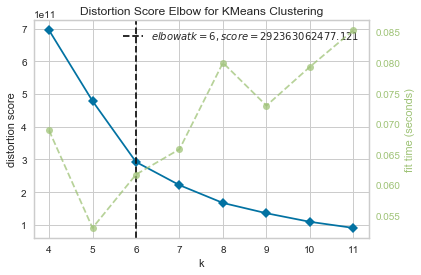

In [52]:
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='distortion', timings=True, locate_elbow = True
)

visualizer.fit(all_cities_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [53]:
# set number of clusters found from using the elbow method above
kclusters = 6



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_cities_grouped_clustering)

In [75]:
# add clustering labels back to the cluster dataframe
all_cities_grouped.insert(0, 'Cluster Labels', kmeans.labels_ +1) # moving cluster labels up by 1 so it looks nicer in the Legend

# renaming the dataframe
all_cities_merged = all_cities_grouped.copy()

all_cities_merged.head() # check the last columns!

,Cluster Labels,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,...,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Name_City,Home Ownership,Home Rentership,Home Value,Median Age,Population Denisty
0,1,Admiral_Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Admiral_Seattle,0.610664,0.327914,531914,43.736842,7051.247368
1,2,Ahwatukee Foothills_Phoenix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Ahwatukee Foothills_Phoenix,0.644995,0.280154,206976,37.663793,4848.015517
2,4,Alahambra_Phoenix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Alahambra_Phoenix,0.460333,0.440082,123621,34.986452,9086.045806
3,3,Alameda_Portland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Alameda_Portland,0.753217,0.208982,423277,42.245833,8170.625000
4,1,Alki_Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Alki_Seattle,0.530444,0.401738,618466,45.528571,7179.071429


In [76]:
all_cities_merged = pd.merge(left = all_cities_merged,
                            right = neighborhoods[['City', 'Name_City', 'Neighborhood', 'Latitude', 'Longitude' ]],
                            left_on = 'Name_City',
                            right_on = 'Name_City',
                            how = 'left')


## Analysis <a name="analysis"></a>

### Visualize each city with the cluster choropleth overlaid

Open all the beautiful boundary box jsons so that the choropleth maps can be made

In [57]:
with open('Austin_geo.json') as json_data:
    austin_geo = json.load(json_data)

with open('Denver_geo.json') as json_data:
    denver_geo = json.load(json_data)

with open('Phoenix_geo.json') as json_data:
    phoenix_geo = json.load(json_data)

with open('Portland_geo.json') as json_data:
    portland_geo = json.load(json_data)

with open('Seattle_geo.json') as json_data:
    seattle_geo = json.load(json_data)

Use Folium's Choropleth maps to vizualize the cluster labels of each neighborhood. Individual maps are needed for each city. The paramater bins is passed to the map function to ensure that the legend stays consistent city to city. 

In [83]:
import folium
from geopy.geocoders import Nominatim

def choropleth_cluster_map(latitude, longitude, data, col_labels, geo_json, bins):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='cartodbpositron')
    folium.Choropleth(
    geo_data = geo_json,
    data = data,
    columns = col_labels,
    key_on = 'feature.id',
    fill_color = 'Set1',
    line_opacty = 0.2,
    legend_name = 'Cluster',
        bins = bins
    
    ).add_to(map_clusters)
    
    for lat, lon, poi, cluster in zip(data['Latitude'], data['Longitude'], data['Neighborhood_y'], data['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='black',
            fill=False).add_to(map_clusters)

    return map_clusters

bins = [*range(1,kclusters+2)]


Start with Seattle. Ballard, our target neighborhood is cluster 3 and filled in with green. Some of the surrounding neighborhoods and across town that I would expect to be similar are labeled with green as well. As vastly different neighborhoods are colored blue and yellow. 

In [144]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="map_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

choropleth_cluster_map(latitude, longitude, 
                       all_cities_merged[all_cities_merged['City'] == 'Seattle'],
                      ['Neighborhood_y', 'Cluster Labels'],
                      seattle_geo, bins)

Display the maps to the other cities to see what similar neighborhoods exist there

In [87]:
address = 'Austin, TX'

geolocator = Nominatim(user_agent="map_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

choropleth_cluster_map(latitude, longitude, 
                       all_cities_merged[all_cities_merged['City'] == 'Austin'],
                      ['Neighborhood_y', 'Cluster Labels'],
                      austin_geo, bins)


In [88]:
address = 'Denver, CO'

geolocator = Nominatim(user_agent="map_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

choropleth_cluster_map(latitude, longitude, 
                       all_cities_merged[all_cities_merged['City'] == 'Denver'].dropna(),
                      ['Neighborhood_y', 'Cluster Labels'],
                      denver_geo, bins)

In [162]:
address = 'Phoenix, AZ'

geolocator = Nominatim(user_agent="map_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

choropleth_cluster_map(latitude, longitude, 
                       all_cities_merged[all_cities_merged['City'] == 'Phoenix'].dropna(),
                      ['Neighborhood_y', 'Cluster Labels'],
                      phoenix_geo, bins)

In [90]:
address = 'Portland, OR'

geolocator = Nominatim(user_agent="map_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

choropleth_cluster_map(latitude, longitude, 
                       all_cities_merged[all_cities_merged['City'] == 'Portland'].dropna(),
                      ['Neighborhood_y', 'Cluster Labels'],
                      portland_geo, bins)

Explore the cluster centroids. Centroids that are closer to 3 are more similar than centroids further away

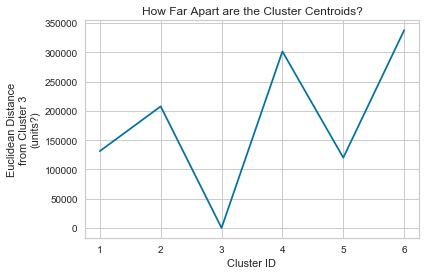

In [93]:
from scipy.spatial import distance
import matplotlib.pyplot as plt
centroid_distances = []
for i in kmeans.cluster_centers_:
    
    p1 = i
    p2 = kmeans.cluster_centers_[2]
    d = distance.euclidean(p1, p2)
    centroid_distances.append(d)
plt.plot(np.arange(0,len(centroid_distances))+1, centroid_distances)
plt.xlabel('Cluster ID')
plt.ylabel('Euclidean Distance\nfrom Cluster 3\n(units?)')
plt.title('How Far Apart are the Cluster Centroids?')
plt.show()

Create a function to find the 10 top most common venue per group. This will be used on each neighborhood and for each cluster

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
import numpy as np
num_top_venues = 10

# first, second, and third. fourth through tenth have common endings
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append(f'{ind+1}{indicators[ind]} Most Common Venue')
    except:
        columns.append(f'{ind+1}th Most Common Venue')

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = all_cities_grouped['Neighborhood']

for ind in np.arange(all_cities_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_cities_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiral_Seattle,Coffee Shop,Pub,American Restaurant,Grocery Store,Pizza Place,Salon / Barbershop,Chinese Restaurant,Cocktail Bar,Gym / Fitness Center,Bookstore
1,Ahwatukee Foothills_Phoenix,Bike Trail,Zoo Exhibit,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory
2,Alahambra_Phoenix,Convenience Store,Bar,Fast Food Restaurant,Intersection,Light Rail Station,Japanese Restaurant,Coffee Shop,Grocery Store,Discount Store,BBQ Joint
3,Alameda_Portland,Garden Center,Italian Restaurant,Optical Shop,Park,Bus Line,Pet Store,Taco Place,Coffee Shop,Rental Car Location,Baseball Field
4,Alki_Seattle,Coffee Shop,Park,Ice Cream Shop,Food Truck,Trail,Italian Restaurant,Beach,Seafood Restaurant,Outdoor Sculpture,Clothing Store


Add the demographic information to the top venues list. Let's also look at the mean values of the demographic data for each cluster.

In [94]:
all_cities_merged[['Home Ownership', 'Home Rentership', 'Home Value','Median Age', 'Population Denisty', 'Cluster Labels']].groupby('Cluster Labels').mean().reset_index()

,Cluster Labels,Home Ownership,Home Rentership,Home Value,Median Age,Population Denisty
0,1,0.541638,0.387761,562483.677419,41.761062,8452.580796
1,2,0.505959,0.411856,223708.462500,36.130668,6561.008287
2,3,0.487702,0.439953,431347.980000,39.892811,9082.096665
3,4,0.413438,0.516924,129842.121212,31.399679,6340.309719
4,5,0.478288,0.448951,311301.366667,38.268215,7800.960587
5,6,0.680126,0.259367,769085.571429,43.702007,5902.288526


In [96]:
venue_cols = [col for col in all_cities_grouped.columns if col not in ['Home Ownership', 'Home Rentership', 'Home Value','Median Age', 'Population Denisty']]
all_cities_grouped.sort_values(by = 'Neighborhood', inplace = True)
all_cities_merged.sort_values(by = 'Name_City', inplace = True)
all_cities_grouped['Cluster Labels'] = all_cities_merged['Cluster Labels']

all_clusters_venues = all_cities_grouped[venue_cols].groupby('Cluster Labels').mean().reset_index()

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Cluster Labels'] = all_clusters_venues['Cluster Labels']

for ind in np.arange(all_clusters_venues.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_clusters_venues.iloc[ind, :], num_top_venues)

cluster_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Park,Coffee Shop,Trail,Pizza Place,Gym,Café,Grocery Store,Playground,Italian Restaurant,Burger Joint
1,2,Park,Coffee Shop,Pizza Place,Convenience Store,Bar,Mexican Restaurant,Sandwich Place,Trail,Brewery,Grocery Store
2,3,Coffee Shop,Park,Trail,Pizza Place,Mexican Restaurant,Bar,Grocery Store,American Restaurant,Playground,Food Truck
3,4,Mexican Restaurant,Convenience Store,Park,Discount Store,Food Truck,Coffee Shop,Pizza Place,Gas Station,Liquor Store,Fast Food Restaurant
4,5,Coffee Shop,Park,Pizza Place,Bar,Mexican Restaurant,Sandwich Place,Grocery Store,Convenience Store,Food Truck,Café
5,6,Park,Bus Stop,Café,Coffee Shop,Trail,Gym,Pharmacy,Soccer Field,Playground,Pizza Place


In [137]:
ballard_values = all_cities_grouped[all_cities_grouped['Neighborhood']=='Ballard_Seattle'][venue_cols]
ballard_values.drop(['Cluster Labels', 'Neighborhood', 'Name_City' ], axis = 1, inplace = True)

columns = ["Neighborhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
ballard_venues_sorted = pd.DataFrame(columns=columns)
ballard_venues_sorted['Neighborhood'] = ['Ballard']
for ind in np.arange(ballard_values.shape[0]):
    ballard_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ballard_values.iloc[0, :], num_top_venues)
    
ballard_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballard,Brewery,Coffee Shop,Bar,Sandwich Place,Mexican Restaurant,Sushi Restaurant,Cocktail Bar,Ice Cream Shop,Pet Store,Dessert Shop
